In the [new growth](./new_growth.ipynb) notebook, we calculate the growth
history of a spherical particle in a cubic box liquid iron containing oxygen
assuming the liquid is always well mixed. The growth rate starts fast
(as the system is far from equilibrium) then slows down and stops as
oxygen partitions from the growing solid into the liquid and phase
equilibrium is approached. However, in a more realistic case oxygen expelled from
the growing solid iron particle will not instantly mix throughout the liquid
volume and a compositional boundary layer will be expected to form. This is
expected to slow the rate of growth (and thus delay the approach to equilibrium).
If we imagine the particle is sinking as it grows the size of the boundary layer
is expected to be set by the sinking velocity, which depends on the radius of the
particle. The interplay between thermodynamics, chemical diffusion, and Stokes
flow could then be rather complicated - but we may be able to perfom a non-equilibrium
calculation akin to the equilbrium calculation of sinking velocity. This could 
let us link the growth rate of the core to the number density of sinking particles,
and thus estimate the sesimic properties of the F-layer.

This notebook is split into two sections. The first considers the growth of a
single particle in a box including the chemical boundary layer, but excluding
movment of the particle (the boundary layer thickness is imposed). The second
accounts for sinking (somehow) and leads to our F-layer calculation. In both
cases growth is coupled to the thermodynamics of Fe-FeO and diffusion through
the boundary layer.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import scipy.integrate as spi
import scipy.optimize as spo

import growth
import feo_thermodynamics

## Set up of box model

As in the new growth notebook, we consider a box of Fe-FeO melt with a fixed overall composition, pressure and temperature starting with a seed crystals with a small radius. We timestep the system and track the composition of the melt and size of the crystal as it grows or dissolves and the system approaches (phase) equilibrium. However, we allow a compositional boundary layer to form around the particle.

The boundary layer forms because there is a flux of oxygen out of the particle as it grows. Derivation is in
the overleaf document, but the relationship between crystal growth rate and oxygen flux at the interface is
given by:

$$\left. \frac{\partial c_l}{\partial r}\right|_{r=r_p} = \frac{c_l(r_p)}{D_l} \frac{\mathrm{d} r_p}{\mathrm{d} t} $$

where $c_l$ is the liquid composition at the particle interface (at $r_p$), $D_l$ is the oxygen diffusion
coefficent, and $t$ is time. $r$ is measured outwards from the center of the particle. The growth rate also
depends on the liquid composition at the particle interface via the chemical potential change:

$$ \frac{\mathrm{d} r_p}{\mathrm{d} t} = k_0 \left[1 - \exp\left(\frac{\Delta\mu(c_l(r_p))}{k_B T}\right)  \right]$$

We assume that the boundary layer structure is linear, increasing from some value at the interface, given by
$c_l(r_p)$, to some other value, $c_l(r_p + \delta)$, at the outer edge of the boundary layer (which has a
thickness $\delta$). This allows us to relate the structure of the boundary layer to the growth rate of the
particle:

$$  c_l(r_p) - c_l(r_p+\delta) = \frac{\delta c_l(r_p)}{D_L} \frac{\mathrm{d} r_p}{\mathrm{d} t} $$

In terms of composition - we work things out in terms of mole fraction Fe (and converting to anything 
else would be a right pain in the ass). We can write the composition in terms of $r$:

$$ x(r) = \begin{cases} 
      1.0 & r \leq r_p  \\
      (c_l - c_0)(r - r_p)/\delta + c_l & r_p\leq r\leq r_p + \delta \\
      c_0 & r_p + \delta \leq r 
   \end{cases}$$
   
Then make sure that the intergral of $x(r)$ is constant from step to step (setting the overall composition:

$$ \frac{4}{3}\pi r^3 x_i = \int_0^R 4 \pi r^2 x(r) \mathrm{d}r$$

(This assumes that changing composition / phase does not impact on volume...)

In [76]:
@numba.vectorize()
def x_r (r, rp, delta, c_outer, c_inner):
    if r < rp:
        comp = 1.0
    elif r < (rp + delta):
        comp = (c_outer - c_inner)*(r - rp)/delta + c_inner
    else:
        comp = c_outer
    return comp

@numba.jit()
def intergrand(r, rp, delta, c_outer, c_inner):
    return 4.0 * np.pi * r**2 * x_r(r, rp, delta, c_outer, c_inner)

def total_composition(rp, delta, c_outer, c_inner, r_max):
    y, err, infodict = spi.quad(intergrand, 0.0, r_max, args=(rp, delta, c_outer, c_inner), full_output=1)
    
    return y
    

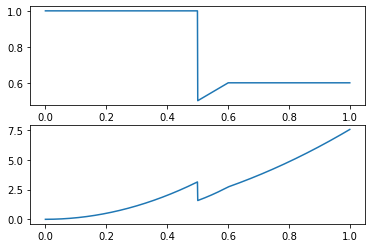

1.0
1.0
1.0
2.7048065549880183


In [81]:
rp = 0.5
delta = 0.1
c_outer = 0.6
c_inner = 0.5

r = np.linspace(0.0, 1.0, 1000)
fig, ax = plt.subplots(nrows=2)
ax[0].plot(r, x_r(r, rp, delta, c_outer, c_inner))
ax[1].plot(r, intergrand(r, rp, delta, c_outer, c_inner))

plt.show()
print(x_r(0.02, rp, delta, c_outer, c_inner))
print(x_r(0.21, rp, delta, c_outer, c_inner))
print(x_r(0.22, rp, delta, c_outer, c_inner))

print(total_composition(rp, delta, c_outer, c_inner, 1.0))

In [83]:
def _total_composition_error(cl, rp, ci, delta, rtot, temperature, pressure, dl, k0):
    """
    For a given cl compute the difference between the composition and the pure
    liquid composition. When this is zero we have a consistent solution
    """
    # Compute growth rate for this composition 
    v = growth.growth_velocity_feo(cl, pressure, temperature, k0)
    # This gives us the composition at the edge of the boundary layer
    # because the graident at the boundary (and hence in the layer)
    # is set by the expulsion rate of O from the growing Fe
    c0 = cl + (delta*cl)/dl * v # Check sign here - it's negative in the notes.
    # Calculate total composition for this configuration
    ctot = total_composition(rp, delta, c0, cl, rtot)
    ctot_pure_melt = 4/3 * np.pi * rtot**3 * ci
    error = ctot - ctot_pure_melt
    return error

def diffusion_growth_rate(rp, ci, delta, rtot, temperature, pressure, dl, k0):
    """
    Compute growth rate of a particle of Fe from an FeO liquid accounting for a diffusional boundary layer
    
    For an Fe particle of radius rp (m) in a spherical container of radius rtot (m)
    calculate drp/dt (in m/s) assuming the presence of a linear boundary layer of
    thickness delta (m) and total composition ci (mol frac Fe) pressute (in GPa) and
    temperature (K). We also need two material properties, the diffusivity of FeO in 
    the liquid (dl, in m^2s^-1) and prefactor for growth (k0, in m/s). We also need
    an initial guess for the liquid composition next to the particle (cl_guess).
    
    Returns the growth rate, the self-consistent composition at the interface
    and the self consistent composition at the outer side of the boundary layer.
    """
    cl = spo.brentq(_total_composition_error, 0.00000001, 0.999999999, 
                    args=(rp, ci, delta, rtot, temperature, pressure, dl, k0))
    
    v = growth.growth_velocity_feo(cl, pressure, temperature, k0)
    c0 = cl + (delta*cl)/dl * v
    return v, cl, c0

In [103]:
r0 = 1.0E-10 # initial radius, m
n = 2 # number of crystals
t = 5000.0 # temperature, K
p = 330.0 # GPa
x = 0.9 # Overall composition, mol frac Fe
k0 = 150.0 # growth rate prefactor, m/s
box_size = 1.0 # initial volume of the box (m^3)
time_step = 0.001 # s
total_time = 0.025 # s
delta = 0.05
r_tot = 1.0

for rp in [0.00001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9]:
    v, cl, c0 = diffusion_growth_rate(rp, x, delta, r_tot, t, p, 1e-9, k0)
    print("At radius", rp, "growth rate is", v, "cl is", cl, "and c0 is", c0)

At radius 1e-05 growth rate is 3.065497855558874e-09 cl is 0.7815058165296108 and c0 is 0.9012910367635263
At radius 0.001 growth rate is 3.065497855558874e-09 cl is 0.7815058165296109 and c0 is 0.9012910367635264
At radius 0.01 growth rate is 3.065497855558874e-09 cl is 0.7815058165296117 and c0 is 0.9012910367635273
At radius 0.1 growth rate is 3.066330522827343e-09 cl is 0.7815058165296158 and c0 is 0.9013235734792091
At radius 0.2 growth rate is 3.0562552488788697e-09 cl is 0.781505816529561 and c0 is 0.9009298792194529
At radius 0.3 growth rate is 3.0176194876219142e-09 cl is 0.7815058165293602 and c0 is 0.8994201756118039
At radius 0.5 growth rate is 2.7622237830371432e-09 cl is 0.7815058165280315 and c0 is 0.8894405141778111
At radius 0.75 growth rate is 1.294581108979287e-09 cl is 0.7815058165203835 and c0 is 0.8320919498516196
At radius 0.9 growth rate is -4.9859449902101005e-09 cl is 0.7815058164876612 and c0 is 0.5866785659608258


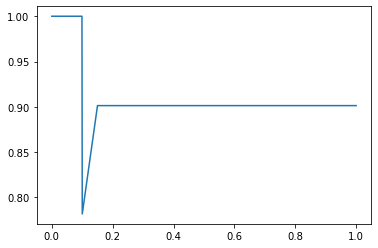

In [104]:
r = np.linspace(0.0, 1.0, 1000)
fig, ax = plt.subplots()
rp = 0.1
v, cl, c0 = diffusion_growth_rate(rp, x, delta, r_tot, t, p, 1e-9, k0)
ax.plot(r, x_r(r, rp, delta, c0, cl))
plt.show()